In [1]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math


In [2]:
%matplotlib inline

In [3]:
Degree = 4 # degree
Height =2 # Height of the tree

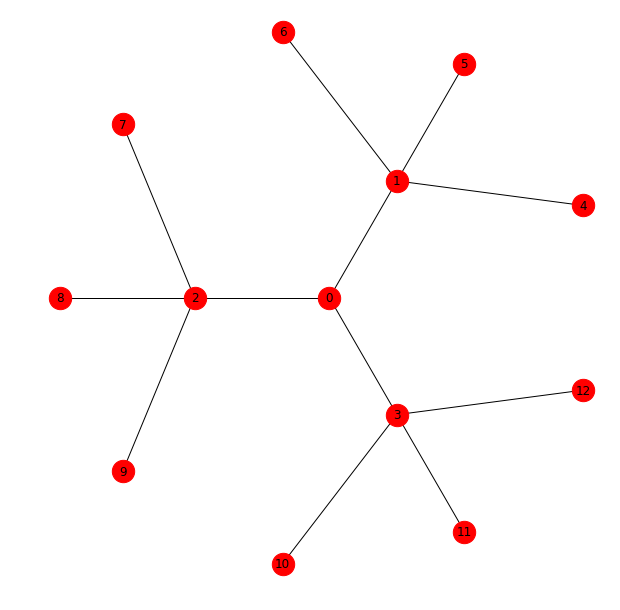

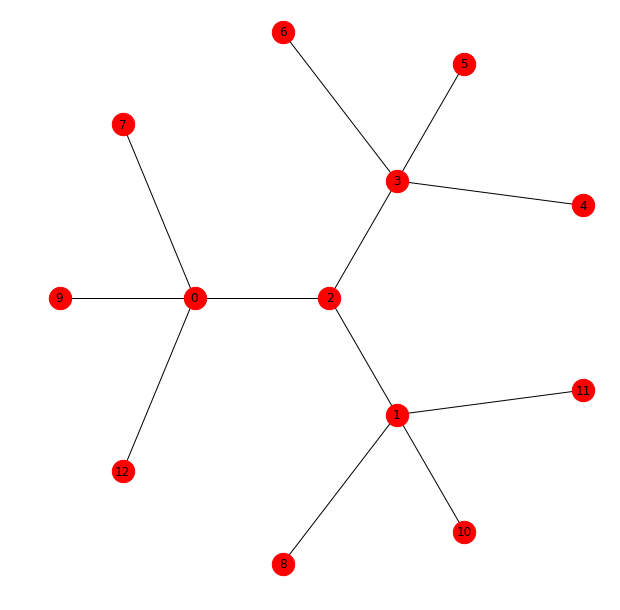

In [11]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

H = np.random.random(N)
#H=np.zeros(N)

num_swap = 1
swaps = [[0,2], [1,3], [12,8]]
J_interaction_rand = J_interaction.copy()
H_rand = H.copy()

for w in swaps:
    rev = list(reversed(w))
    J_interaction_rand[w] = J_interaction_rand[rev] 
    J_interaction_rand[:,w] = J_interaction_rand[:,rev] 
    H_rand[w] = H_rand[rev]
J_interaction_rand
graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(1e-6,2,1e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [12]:
import model
import imp
imp.reload(model)
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

fe_ex = []
ener_ex = []
m_ex = []
m_i_ex = []
for beta in betas_fast:
    tree.exact(beta)
    fe_ex.append(tree.free_energy)
    ener_ex.append(tree.E_mean)
    m_ex.append(tree.M_mean)
    m_i_ex.append(tree.M_i_mean)

beta: 0.0, Fe: -693147.181 Energy: -1.32e-06 M: 5.6e-07 S: 0.693
beta: 0.1, Fe: -7.000 Energy: -0.142 M: 0.0683 S: 0.686
beta: 0.2, Fe: -3.611 Energy: -0.308 M: 0.167 S: 0.661
beta: 0.3, Fe: -2.543 Energy: -0.507 M: 0.301 S: 0.611
beta: 0.4, Fe: -2.061 Energy: -0.725 M: 0.458 S: 0.534
beta: 0.5, Fe: -1.815 Energy: -0.931 M: 0.608 S: 0.442
beta: 0.6, Fe: -1.682 Energy: -1.1 M: 0.726 S: 0.352
beta: 0.7, Fe: -1.607 Energy: -1.21 M: 0.809 S: 0.277
beta: 0.8, Fe: -1.563 Energy: -1.29 M: 0.865 S: 0.218
beta: 0.9, Fe: -1.536 Energy: -1.34 M: 0.902 S: 0.172
beta: 1.0, Fe: -1.519 Energy: -1.38 M: 0.928 S: 0.137
beta: 1.1, Fe: -1.507 Energy: -1.41 M: 0.947 S: 0.109
beta: 1.2, Fe: -1.500 Energy: -1.43 M: 0.96 S: 0.0866
beta: 1.3, Fe: -1.495 Energy: -1.44 M: 0.97 S: 0.0691
beta: 1.4, Fe: -1.492 Energy: -1.45 M: 0.977 S: 0.0551
beta: 1.5, Fe: -1.489 Energy: -1.46 M: 0.983 S: 0.044
beta: 1.6, Fe: -1.488 Energy: -1.47 M: 0.987 S: 0.0351
beta: 1.7, Fe: -1.486 Energy: -1.47 M: 0.99 S: 0.0279
beta: 1.8,

In [26]:
m_i_nn

[array([-3.90e-03,  9.42e-03, -3.06e-03,  2.66e-03, -4.00e-05, -3.26e-03,
        -1.20e-03, -8.80e-04, -3.40e-04, -6.10e-03, -3.32e-03,  3.68e-03,
        -5.60e-04], dtype=float32),
 array([0.03078, 0.1027 , 0.07726, 0.10488, 0.08488, 0.10866, 0.04048,
        0.08408, 0.04582, 0.06538, 0.07922, 0.02416, 0.03642],
       dtype=float32),
 array([0.1299 , 0.2534 , 0.19364, 0.23322, 0.19584, 0.22856, 0.11102,
        0.19196, 0.11456, 0.15126, 0.17264, 0.07056, 0.10604],
       dtype=float32),
 array([0.31058, 0.43724, 0.35656, 0.40468, 0.33234, 0.38384, 0.21372,
        0.31368, 0.20758, 0.2712 , 0.30094, 0.15402, 0.20408],
       dtype=float32),
 array([0.5301 , 0.64286, 0.5549 , 0.59186, 0.48738, 0.53398, 0.3511 ,
        0.46736, 0.33806, 0.40752, 0.44326, 0.27094, 0.33548],
       dtype=float32),
 array([0.7259 , 0.80062, 0.7351 , 0.74836, 0.6274 , 0.6775 , 0.4912 ,
        0.61284, 0.4793 , 0.55582, 0.57822, 0.40016, 0.47026],
       dtype=float32),
 array([0.85954, 0.90044, 0.854

In [25]:
import imp
import bp_nn
imp.reload(bp_nn)

fe_nn = []
ener_nn = []
m_nn = []
m_i_nn = []
net = bp_nn.bp_nn(N, tree, True, z2=False, 
                x_hat_clip=True )

for beta in betas_fast:
    
    net.train(beta = beta, lr=0.005, max_step=1000, 
              batch_size=1000,
             opt = "adam")
    
    net.compute_stat(beta, batch_size = 100000)
    fe_nn.append(net.F)
    ener_nn.append(net.E)
    m_nn.append(net.M)
    m_i_nn.append(net.M_i)


 0.00 1000 fe: -693147.186 +- 0.05058 E: 0.010, S: 0.693, M: -0.00462, W: 1.88231e-06, 1.99123e-06, Bias: 0.000000 - 0.000002
 0.10 150 fe: -7.000 +- 0.00010 E: -0.136, S: 0.686, M: 0.074, W: 0.200005, 0.19996, Bias: 0.064083 - 0.199908
 0.20 149 fe: -3.611 +- 0.00009 E: -0.304, S: 0.661, M: 0.164, W: 0.399865, 0.399947, Bias: 0.269063 - 0.479167
 0.30 167 fe: -2.543 +- 0.00009 E: -0.513, S: 0.609, M: 0.303, W: 0.600053, 0.599877, Bias: 0.643410 - 0.829351
 0.40 294 fe: -2.061 +- 0.00010 E: -0.736, S: 0.530, M: 0.462, W: 0.800048, 0.799976, Bias: 1.180490 - 1.242742
 0.50 418 fe: -1.815 +- 0.00009 E: -0.943, S: 0.436, M: 0.614, W: 1.00006, 1.00001, Bias: 1.844492 - 1.705766
 0.60 486 fe: -1.682 +- 0.00010 E: -1.098, S: 0.350, M: 0.732, W: 1.20017, 1.19997, Bias: 2.585208 - 2.207842
 0.70 526 fe: -1.607 +- 0.00010 E: -1.207, S: 0.280, M: 0.808, W: 1.40129, 1.40058, Bias: 3.358856 - 2.738167
 0.80 519 fe: -1.563 +- 0.00010 E: -1.282, S: 0.225, M: 0.859, W: 1.60489, 1.60308, Bias: 4.13457

In [27]:
import imp
import bp_nn
imp.reload(bp_nn)

fe_nn_rand = []
ener_nn_rand = []
m_nn_rand = []
m_i_nn_rand = []


net_rand = bp_nn.bp_nn(N, tree_rand, True, z2=False)

for beta in betas_fast:
    net_rand.train(beta = beta, opt = "adam",  lr=0.005 ,
                   max_step=1000, batch_size=1000)
    net_rand.compute_stat(beta, batch_size = 100000)
    fe_nn_rand.append(net_rand.F)
    ener_nn_rand.append(net_rand.E)
    m_nn_rand.append(net_rand.M)
    m_i_nn_rand.append(net_rand.M_i)


 0.00 1000 fe: -693147.178 +- 0.04427 E: 0.003, S: 0.693, M: 0.00369, W: -0.0, 2.03471e-06, Bias: 0.000001 - 0.000002
 0.10 1000 fe: -7.001 +- 0.00759 E: -0.147, S: 0.685, M: 0.0718, W: -0.0, 0.200135, Bias: 0.146257 - 0.205788
 0.20 1000 fe: -3.610 +- 0.01420 E: -0.299, S: 0.662, M: 0.164, W: -0.0, 0.39964, Bias: 0.392076 - 0.484373
 0.30 1000 fe: -2.542 +- 0.01835 E: -0.503, S: 0.612, M: 0.3, W: -0.0, 0.600076, Bias: 0.767926 - 0.864210
 0.40 1000 fe: -2.060 +- 0.01732 E: -0.730, S: 0.532, M: 0.458, W: -0.0, 0.804681, Bias: 1.281670 - 1.370303
 0.50 1000 fe: -1.815 +- 0.01404 E: -0.935, S: 0.440, M: 0.612, W: -0.0, 0.996073, Bias: 1.902366 - 1.968799
 0.60 1000 fe: -1.681 +- 0.00794 E: -1.076, S: 0.363, M: 0.716, W: -0.0, 1.20207, Bias: 2.602003 - 2.638466
 0.70 1000 fe: -1.607 +- 0.00583 E: -1.211, S: 0.277, M: 0.807, W: -0.0, 1.40247, Bias: 3.324204 - 3.318752
 0.80 1000 fe: -1.563 +- 0.00046 E: -1.282, S: 0.225, M: 0.859, W: -0.0, 1.58302, Bias: 4.055904 - 3.997090
 0.90 1000 fe: 

In [15]:
import bp_solver
imp.reload(bp_solver)

fe_bp = []
ener_bp = []
m_bp = []
m_i_bp = []
BP_tree = bp_solver.BP_solver(tree) 

for beta in betas_fast:
    
    BP_tree.converge(beta, error = 1e-6)
    fe_bp.append(BP_tree.F)
    ener_bp.append(BP_tree.E_mean)
    m_bp.append(BP_tree.M_mean)
    m_i_bp.append(BP_tree.M_i)

fe: -693147.181, ener: -0.000, M: 0.000
fe: -7.000, ener: -0.142, M: 0.068
fe: -3.611, ener: -0.308, M: 0.167
fe: -2.543, ener: -0.507, M: 0.301
fe: -2.061, ener: -0.725, M: 0.458
fe: -1.815, ener: -0.931, M: 0.608
fe: -1.682, ener: -1.095, M: 0.726
fe: -1.607, ener: -1.212, M: 0.809
fe: -1.563, ener: -1.291, M: 0.865
fe: -1.536, ener: -1.345, M: 0.902
fe: -1.519, ener: -1.382, M: 0.928
fe: -1.507, ener: -1.409, M: 0.947
fe: -1.500, ener: -1.428, M: 0.960
fe: -1.495, ener: -1.442, M: 0.970
fe: -1.492, ener: -1.452, M: 0.977
fe: -1.489, ener: -1.460, M: 0.983
fe: -1.488, ener: -1.466, M: 0.987
fe: -1.486, ener: -1.470, M: 0.990
fe: -1.486, ener: -1.473, M: 0.992
fe: -1.485, ener: -1.476, M: 0.994


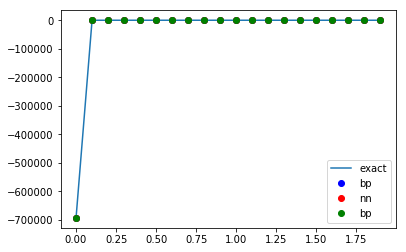

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
plt.plot(x, fe_ex, label = "exact")
plt.plot(x,fe_bp, "bo", label="bp")
plt.plot(x,fe_nn, "ro", label="nn")
plt.plot(x,fe_nn_rand, "go", label="bp")
plt.legend()
plt.show()

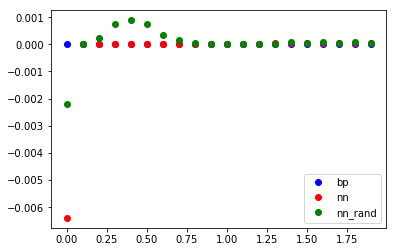

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
fe_ex = np.array(fe_ex)
fe_bp = np.array(fe_bp)
fe_nn = np.array(fe_nn)
fe_nn_rand = np.array(fe_nn_rand)

plt.plot(x, fe_bp - fe_ex, "bo", label="bp")
plt.plot(x, fe_nn - fe_ex, "ro", label="nn")
plt.plot(x, fe_nn_rand - fe_ex, "go", label="nn_rand")

plt.legend()
plt.show()

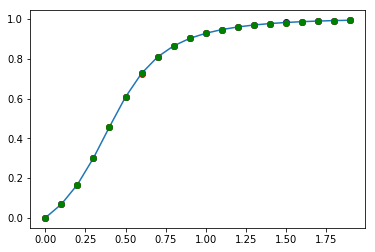

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast
plt.plot(x, m_ex, label = "exact")
plt.plot(x,m_bp, "bo", label="bp")
plt.plot(x,m_nn, "ro", label="nn")
plt.plot(x,m_nn_rand, "go", label="nn")
plt.legend
plt.show()

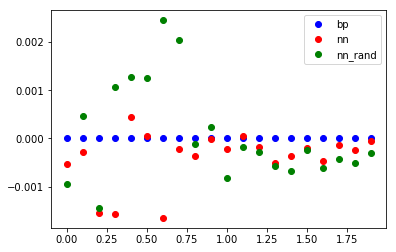

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast

m_ex = np.array(m_ex)
m_bp = np.array(m_bp)
m_nn = np.array(m_nn)
m_nn_rand = np.array(m_nn_rand)

plt.plot(x, m_bp - m_ex, "bo", label="bp")
plt.plot(x, m_nn - m_ex, "ro", label="nn")
plt.plot(x, m_nn_rand - m_ex, "go",label = "nn_rand")

plt.legend()
plt.show()

In [31]:
m_i_nn

[array([-3.90e-03,  9.42e-03, -3.06e-03,  2.66e-03, -4.00e-05, -3.26e-03,
        -1.20e-03, -8.80e-04, -3.40e-04, -6.10e-03, -3.32e-03,  3.68e-03,
        -5.60e-04], dtype=float32),
 array([0.03078, 0.1027 , 0.07726, 0.10488, 0.08488, 0.10866, 0.04048,
        0.08408, 0.04582, 0.06538, 0.07922, 0.02416, 0.03642],
       dtype=float32),
 array([0.1299 , 0.2534 , 0.19364, 0.23322, 0.19584, 0.22856, 0.11102,
        0.19196, 0.11456, 0.15126, 0.17264, 0.07056, 0.10604],
       dtype=float32),
 array([0.31058, 0.43724, 0.35656, 0.40468, 0.33234, 0.38384, 0.21372,
        0.31368, 0.20758, 0.2712 , 0.30094, 0.15402, 0.20408],
       dtype=float32),
 array([0.5301 , 0.64286, 0.5549 , 0.59186, 0.48738, 0.53398, 0.3511 ,
        0.46736, 0.33806, 0.40752, 0.44326, 0.27094, 0.33548],
       dtype=float32),
 array([0.7259 , 0.80062, 0.7351 , 0.74836, 0.6274 , 0.6775 , 0.4912 ,
        0.61284, 0.4793 , 0.55582, 0.57822, 0.40016, 0.47026],
       dtype=float32),
 array([0.85954, 0.90044, 0.854

In [32]:
m_i_ex

array([[5.10262907e-08, 7.93974323e-07, 5.24880306e-07, 8.91690433e-07,
        7.75522494e-07, 9.73865099e-07, 3.12407792e-07, 8.17504770e-07,
        3.86520696e-07, 6.08262781e-07, 6.76089257e-07, 1.38788891e-07,
        3.34279321e-07],
       [3.20327491e-02, 1.01748237e-01, 7.29126493e-02, 1.02462573e-01,
        8.66720519e-02, 1.06178191e-01, 4.10472021e-02, 8.80104057e-02,
        4.55050026e-02, 6.73937787e-02, 7.70297299e-02, 2.39666124e-02,
        4.33107241e-02],
       [1.33677246e-01, 2.51299211e-01, 1.93374795e-01, 2.36903965e-01,
        1.96405910e-01, 2.32967321e-01, 1.09383794e-01, 1.93159484e-01,
        1.12109032e-01, 1.54041533e-01, 1.75248444e-01, 7.34259281e-02,
        1.10775127e-01],
       [3.11129955e-01, 4.41841488e-01, 3.63358781e-01, 4.05387223e-01,
        3.32511149e-01, 3.80959506e-01, 2.13253357e-01, 3.21420268e-01,
        2.10317873e-01, 2.68316077e-01, 2.97550664e-01, 1.56038240e-01,
        2.08627557e-01],
       [5.30476279e-01, 6.40720370e-

In [37]:
x

array([1.000000e-06, 1.000010e-01, 2.000010e-01, 3.000010e-01,
       4.000010e-01, 5.000010e-01, 6.000010e-01, 7.000010e-01,
       8.000010e-01, 9.000010e-01, 1.000001e+00, 1.100001e+00,
       1.200001e+00, 1.300001e+00, 1.400001e+00, 1.500001e+00,
       1.600001e+00, 1.700001e+00, 1.800001e+00, 1.900001e+00])

In [ ]:
sum(abs(m_i_bp - m_i_ex))

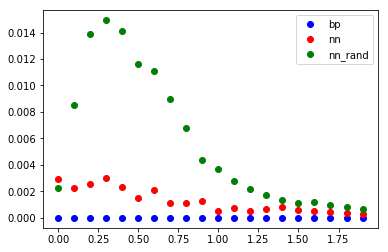

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
x = betas_fast

m_i_ex = np.array(m_i_ex)
#m_bp = np.array(m_bp)
m_i_nn = np.array(m_i_nn)
m_i_nn_rand = np.array(m_i_nn_rand)

plt.plot(x, abs(m_i_bp - m_i_ex).sum(axis=1)/N, "bo", label="bp")
plt.plot(x, abs(m_i_nn - m_i_ex).sum(axis=1)/N, "ro", label="nn")
plt.plot(x, abs(m_i_nn_rand - m_i_ex).sum(axis=1)/N, "go",label = "nn_rand")

plt.legend()
plt.show()